In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import itertools

In [2]:
class GridSearch:
    def __init__(self, estimator, param_grid, scoring=None, nfolds=5):
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring if scoring else mean_squared_error
        self.nfolds = nfolds
    
    def fit(self, X, y=None):
        param_names = list(self.param_grid.keys())
        param_values = list(itertools.product(*self.param_grid.values()))

        result = []

        best_score = np.inf
        best_params = []
        
        for p in param_values:
            mapping = {param_names[i]:p[i] for i in range(len(param_names))}
            model = self.estimator(**mapping)

            kf = KFold(n_splits=self.nfolds, random_state=None, shuffle=False)
            scores = []
            
            for i, (train_index, test_index) in enumerate(kf.split(X)):
                X_train = X[train_index]
                X_test = X[test_index]

                y_train = y[train_index]
                y_test = y[test_index] 

                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                score = self.scoring(y_test, y_pred)
                scores.append(score)
            
            cv_score = np.mean(scores)
            result.append(
                (mapping, cv_score)
            )

            if cv_score < best_score:
                best_score = cv_score
                best_params = p
        
        self.best_score = best_score
        self.best_params = best_params

        self.cv_results = result


In [68]:
x = np.linspace(-10, 10, 100)

f1 = lambda x: np.sin(4*x) #+ np.random.normal(0, 0.1, len(x))
f2 = lambda x: np.sin(4*x) #+ np.random.normal(0, 0.1, len(x))

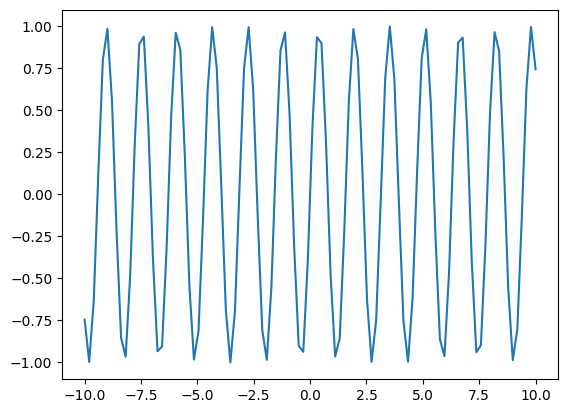

In [70]:
# plt.plot(x, f1(x))
plt.plot(x, f2(x))

In [283]:
def kernel(x1, x2, bandwidth):
    return np.exp(-(x2[np.newaxis, :] - x1[:, np.newaxis])**2/(2*bandwidth**2))


class KRR:
    def __init__(self, bandwidth, reg):
        self.bandwidth = bandwidth
        self.reg = reg

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K = kernel(X_train, X_train, self.bandwidth)

        self.alpha = np.linalg.inv(K - self.reg*np.eye(len(X_train)))@y_train

    def predict(self, X_test):
        return kernel(X_test, self.X_train, self.bandwidth)@self.alpha
        

def functionize(model):
    return lambda x: model.predict(x)

In [284]:
gridsearch = GridSearch(
    KRR,
    param_grid=dict(
        bandwidth = np.linspace(0.01, 5, 50),
        reg = np.linspace(1e-4, 1e-12, 50),
    ),
    scoring=mean_squared_error
)

In [285]:
# gridsearch.fit(x, f1(x))
# bandwidth, reg = gridsearch.best_params
# print(bandwidth, reg)

# model = KRR(bandwidth=1, reg=1e-9)
# model.fit(x, f1(x))
# f1_predict = functionize(model)

# gridsearch.fit(x, f2(x))
# bandwidth, reg = gridsearch.best_params
# print(bandwidth, reg)

# model = KRR(bandwidth=bandwidth, reg=reg)
# model.fit(x, f2(x))
# f2_predict = functionize(model)

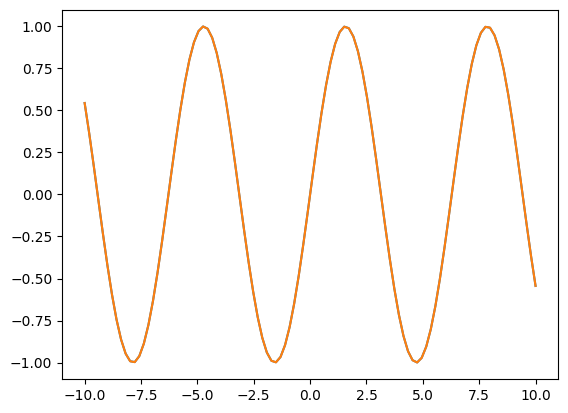

In [286]:
model = KRR(bandwidth=1, reg=1e-12)
model.fit(x, f1(x))
f1_predict = functionize(model)

plt.plot(x, f1(x))
plt.plot(x, f1_predict(x))

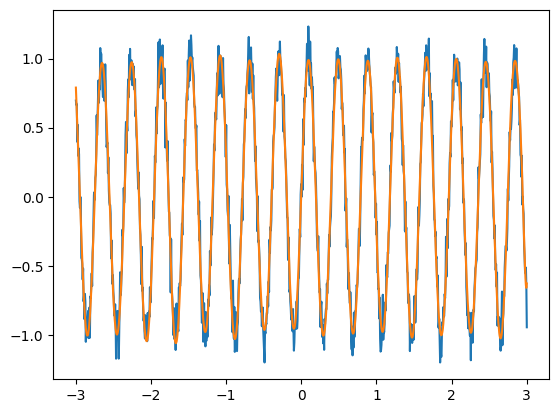

In [10]:
model = KRR(bandwidth=0.1, reg=1e-12)
model.fit(x, f2(x))
f2_predict = functionize(model)

plt.plot(x, f2(x))
plt.plot(x, f2_predict(x))

In [21]:
np.linalg.cholesky(kernel(x, x, 1))

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.20076348e-01, 3.91739089e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.16630794e-01, 6.65548348e-01, 2.08532253e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.22157810e-80, 7.21326738e-77, 2.65326008e-73, ...,
        1.78673756e-02, 0.00000000e+00, 0.00000000e+00],
       [4.46877576e-84, 3.11729662e-80, 1.35459511e-76, ...,
        1.07088984e-01, 1.78643683e-02, 0.00000000e+00],
       [1.38389653e-87, 1.14042805e-83, 5.85434135e-80, ...,
        2.94266031e-01, 1.07076491e-01, 1.78618234e-02]], shape=(50, 50))

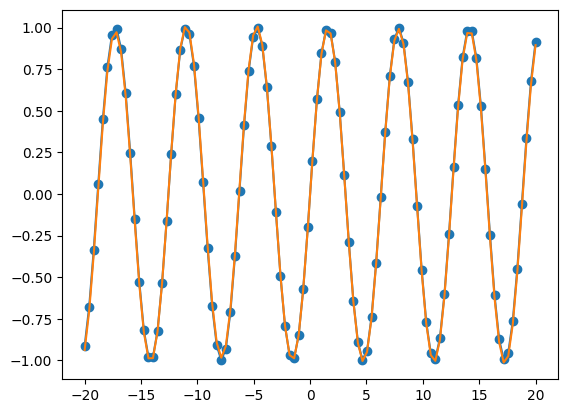

In [222]:
x = np.linspace(-20, 20, 100)

f2 = lambda x: np.sin(x)

bw = 5

model = KRR(bandwidth=bw, reg=1e-9)
model.fit(x, f2(x))

l = 1e-8

bw2 = 1
beta = np.linalg.inv(kernel(x*(bw2/bw), x*(bw2/bw), bw2) + l*np.eye(len(x)))@ (kernel(x, x, bw) + l*np.eye(len(x)))@model.alpha
y_pred = kernel(x/bw, x/bw, bw2)@beta

plt.scatter(x, f2(x))
plt.plot(x, model.predict(x))
plt.plot(x, y_pred)

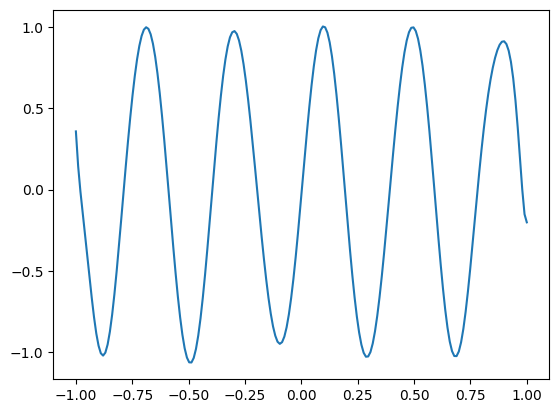

In [134]:
model = KRR(bandwidth=0.1, reg=1e-12)
model.fit(x, f2(x))
plt.plot(x, model.predict(x))

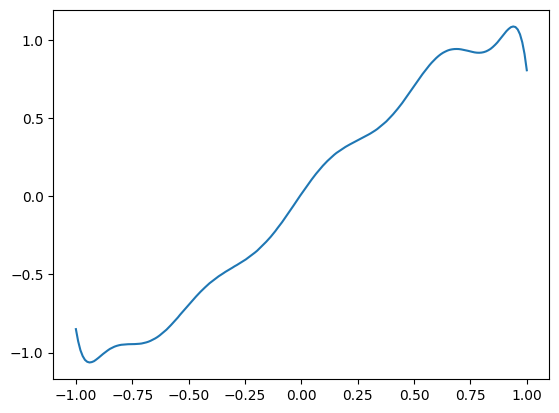

In [138]:
model = KRR(bandwidth=1, reg=1e-12)
model.fit(x, f2(x*0.1))


plt.plot(x, model.predict(x))

In [306]:
x = np.linspace(-10, 10, 100)

f1 = lambda x: np.sin(x) #+ np.random.normal(0, 0.1, len(x))
f2 = lambda x: np.sin(2*x) #+ np.random.normal(0, 0.1, len(x))

In [307]:
gridsearch = GridSearch(
    KRR,
    param_grid=dict(
        bandwidth = np.linspace(0.01, 5, 30),
        reg = np.linspace(1e-4, 1e-12, 10),
    ),
    scoring=mean_squared_error
)

In [329]:
model1 = KRR(bandwidth=2, reg=1e-12)
model1.fit(x, f1(x))
f1_predict = functionize(model1)

model2 = KRR(bandwidth=3, reg=1e-12)
model2.fit(x, f1(x))
f2_predict = functionize(model2)

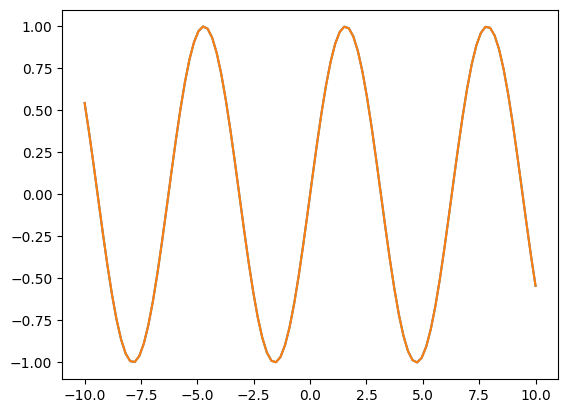

In [330]:
plt.plot(x, f1(x))
plt.plot(x, f1_predict(x))

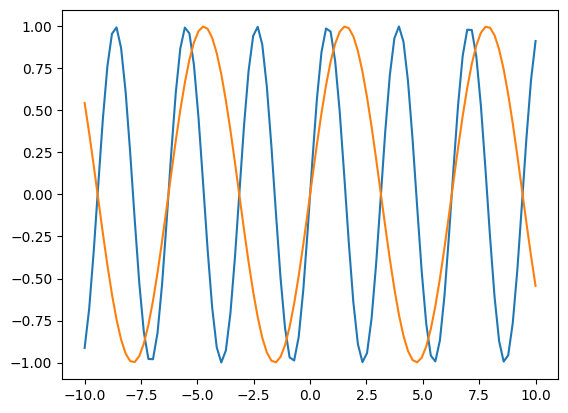

In [331]:
plt.plot(x, f2(x))
plt.plot(x, f2_predict(x))

In [341]:
s1 = 2
s2 = 3

a = s2/s1

d11 = model1.alpha.T@kernel(x, x, s1)@model1.alpha
d22 = model2.alpha.T@kernel(x, x, s2)@model2.alpha

d12 = model1.alpha.T@kernel(a*x*s1/s2, a*x*s1/s2, s1)@model2.alpha

d11 + d22 - 2*d12
d11, d22, d12, d11 + d22 - 2*d12

(np.float64(35.91327895623181),
 np.float64(205.61543348361738),
 np.float64(-201.46511677317903),
 np.float64(644.4589459862073))

In [349]:
s1 = 2
s2 = 3

a = 1

d11 = model1.alpha.T@kernel(x, x, s1)@model1.alpha
d22 = model2.alpha.T@kernel(a*x, a*x, s2)@model2.alpha

d12 = model1.alpha.T@kernel(a*x*s1/s2, a*x*s1/s2, s1)@model2.alpha

d11 + d22 - 2*d12
d11, d22, d12, d11 + d22 - 2*d12

(np.float64(35.91327895623181),
 np.float64(205.61543348361738),
 np.float64(18.66921500425815),
 np.float64(204.1902824313329))